In [4]:
%load_ext autoreload
%autoreload 2

import wandb
import torch
from einops import rearrange
from text3d2video.artifacts.multiview_features_artifact import MVFeaturesArtifact
from text3d2video.wandb_util import first_used_artifact_of_type
from text3d2video.artifacts.animation_artifact import AnimationArtifact
from matplotlib import pyplot as plt
from text3d2video.visualization import RgbPcaUtil
import text3d2video.wandb_util as wu

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from text3d2video.wandb_util import api_artifact

mv_features_tag  = 'deadpool-mv-features:v4'
mv_features = wu.get_artifact(mv_features_tag)
mv_features = MVFeaturesArtifact.from_wandb_artifact(mv_features)
animation = mv_features.get_animation_from_lineage()
mesh = animation.load_static_mesh()

mv_features_run_config = mv_features.logged_by().config

wandb: Downloading large artifact deadpool-mv-features:v4, 3446.13MB. 82 files... 
wandb:   82 of 82 files downloaded.  
Done. 0:0:1.0
wandb: Downloading large artifact backflip:v0, 121.09MB. 61 files... 
wandb:   61 of 61 files downloaded.  
Done. 0:0:0.4
/home/jorge/miniconda3/envs/thesis/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


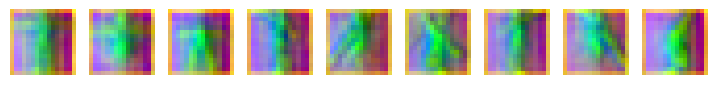

In [11]:
feature_id = {'layer':'level_0', 'timestep': 20}
features = [mv_features.get_feature(i, feature_id) for i in mv_features.view_indices()]

all_features = torch.stack(features)

all_features = rearrange(all_features, 'v c h w -> (v h w) c')
pca = RgbPcaUtil(all_features.shape[1])
pca.fit(all_features)

features_rgb = [pca.feature_map_to_rgb(feature) for feature in features]

cams = mv_features.get_cameras()

N = len(features_rgb)
scale = 1
fig, axs = plt.subplots(1, N, figsize=(scale*N, scale))
for i in range(N):
    axs[i].imshow(features_rgb[i].permute(1,2,0))
    axs[i].axis('off')